<a href="https://colab.research.google.com/github/shabrii-naa/Spotify-Sentiment-Analysis/blob/main/Analisis_Sentiment_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Sentimen pada Aplikasi Spotify Berdasarkan Google Play Reviews**

Nama: Shabrina Aulia Hidayat

NIM: 2304643

## **1. Import Library**
Mengimpor library seperti **pandas dan numpy** digunakan untuk manipulasi data, **matplotlib dan seaborn** untuk visualisasi, sementara **nltk dan Sastrawi** untuk pemrosesan bahasa alami seperti tokenisasi dan stemming serta **scikit-learn** untuk ekstraksi fitur tekstual (TF-IDF dan BoW), pembangunan model (SVM dan Logistic Regression) & evaluasi performa.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string
import nltk
nltk.download("punkt_tab")
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud
from collections import Counter

#import pustaka pelabelan data
import csv
import requests
from io import StringIO

#import pustaka untuk ekstraksi fitur teks
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Import Library
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Insert and Check Dataset**
Untuk **memahami struktur data**, termasuk jumlah baris dan kolom, tipe data setiap kolom, serta memeriksa duplikat. Tahap ini berguna untuk **memastikan data telah terbaca** dengan benar dan **memberikan gambaran awal** tentang karakteristik dataset sebelum dilakukan pemrosesan lebih lanjut. Hasil pengecekan menunjukkan **dataset terdiri dari 31.500 ulasan dengan empat kolom utama.**

In [ ]:
dataset_path = "spotify.csv"
spotify_df = pd.read_csv(dataset_path, on_bad_lines='skip', delimiter=',')

In [ ]:
spotify_df.head()

,userName,score,at,content
0,Pengguna Google,1,2025-12-20 15:07:50,Selama ini ga masalah sama iklan yg byk untuk ...
1,Pengguna Google,1,2025-12-21 08:24:09,SUMPAH GEDEG BGT. IKLAN NYA BANYAK BGT ANJR?! ...
2,Pengguna Google,5,2025-12-14 05:43:02,Sebenarnya Spotify ini udah jadi platform musi...
3,Pengguna Google,4,2025-12-15 14:45:44,"bagus, aku sukaa, enak bisa sambil dengerin la..."
4,Pengguna Google,1,2025-12-14 23:57:42,"iklan lebih sering, hampir setiap 1 lagu diput..."


In [ ]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  31500 non-null  object
 1   score     31500 non-null  int64 
 2   at        31500 non-null  object
 3   content   31500 non-null  object
dtypes: int64(1), object(3)
memory usage: 984.5+ KB


In [ ]:
print(f"Total Dataset {spotify_df.shape[0]} rows and {spotify_df.shape[1]} columns")

Total Dataset 31500 rows and 4 columns


In [ ]:
print("Jumlah duplikasi:", spotify_df.duplicated().sum())

Jumlah duplikasi: 0


## **3. Preprocessing Text**
Tahapan preprocessing bertujuan untuk **mengurangi noise** pada data teks dan **menyederhanakan variasi** kata sehingga fitur yang dihasilkan lebih representatif.

Proses yang dilakukan meliputi **case folding, cleaning teks dengan menghapus URL, simbol, angka, dan tanda baca, tokenisasi, penghapusan stopword bahasa Indonesia dan Inggris, serta stemming untuk mengubah kata ke bentuk dasar**. Hasil preprocessing berupa teks bersih yang siap digunakan pada tahap ekstraksi fitur.

In [ ]:
#Membuat Filter Cleaning, Case Folding, Tokenizing, Stemming dan Menyatukan kata
def cleaning_text(text):
  "Membersikah teks dengan hapus mention, link, angka, dan tanda baca"
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) #Hapus mention
  text = re.sub(r'#', '', text) #Hapus hastag
  text = re.sub(r'RT :', '', text) #Hapus RT
  text = re.sub(r'https?:\/\/\S+', '', text) #Hapus link
  text = re.sub(r'\d+', '', text) #Hapus angka
  text = text.translate(str.maketrans('', '', string.punctuation)) #Hapus tanda baca
  return text
def casefolding_text(text):
  return text.lower()
def tokenizing_text(text):
  return word_tokenize(text)
def stemming_text(text):
  stemmer = factory.create_stemmer()
  return ''.join([stemmer.stem(word) for word in text.split()])
def to_sentence(words):
  return ' '.join(words)

In [ ]:
#Adding new column for the clean text after filtering
spotify_df['clean_text'] = spotify_df['content'].apply(cleaning_text)

In [ ]:
def filtering_text(text):
  ##menghapus kata-kata yang tidak penting
  stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
  additional_stopwords = ['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy', 'yg', 'ya', 'aja']
  stop_words.update(additional_stopwords)
  return [word for word in text if word not in stop_words]

In [ ]:
## Dataset duplication and text preprocessing
new_spotify_df = spotify_df.copy()
new_spotify_df['text_clean'] = new_spotify_df['content'].apply(cleaning_text)
new_spotify_df['text_casefolding']= new_spotify_df['text_clean'].apply(casefolding_text)
new_spotify_df['text_tokenizing'] = new_spotify_df['text_casefolding'].apply(tokenizing_text)
new_spotify_df['text_filtering'] = new_spotify_df['text_tokenizing'].apply(filtering_text)
new_spotify_df['text_final'] = new_spotify_df['text_filtering'].apply(to_sentence)

## **4. Pelabelan Dataset**

Pelabelan sentimen dilakukan menggunakan **metode lexicon-based** dengan memanfaatkan kamus kata positif dan negatif berbahasa Indonesia. Setiap ulasan diberi **label positif, negatif, atau netral berdasarkan skor sentimen** yang dihasilkan.

Kelas netral diperlukan untuk **menampung ulasan yang tidak mengandung kata bermuatan sentimen** atau memiliki keseimbangan antara kata positif dan negatif. Dengan tiga kelas ini, hasil analisis menjadi **lebih representatif dan mencerminkan kondisi sentimen pengguna** secara lebih realistis.

Metode ini dipilih karena **efisien untuk dataset berukuran besar, tidak memerlukan pelabelan manual**, serta sesuai untuk analisis sentimen ulasan berbahasa Indonesia.

In [ ]:
# Fungsi untuk memuat data lexicon positif dari GitHub
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)  # Mengirim permintaan HTTP untuk mendapatkan file CSV
    if response.status_code == 200:
        # Jika permintaan berhasil, membaca CSV
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            lexicon[row[0]] = int(row[1])  # Menambahkan kata dan skornya ke dalam kamus
    else:
        print(f"Failed to fetch lexicon data from {url}")
    return lexicon

# Memuat lexicon positif
lexicon_positive_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_positive = load_lexicon(lexicon_positive_url)

# Memuat lexicon negatif
lexicon_negative_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
lexicon_negative = load_lexicon(lexicon_negative_url)

# Menampilkan beberapa contoh data lexicon positif dan negatif
print("Contoh kata positif:", list(lexicon_positive.items())[:5])  # Menampilkan 5 kata pertama
print("Contoh kata negatif:", list(lexicon_negative.items())[:5])  # Menampilkan 5 kata pertama

Contoh kata positif: [('hai', 3), ('merekam', 2), ('ekstensif', 3), ('paripurna', 1), ('detail', 2)]
Contoh kata negatif: [('putus tali gantung', -2), ('gelebah', -2), ('gobar hati', -2), ('tersentuh (perasaan)', -1), ('isak', -5)]


In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    """
    Menganalisis sentimen teks berdasarkan lexicon positif dan negatif
    Args:
    - text: List kata-kata dari teks yang akan dianalisis

    Returns:
    - score: Skor sentimen dari teks
    - polarity: Polaritas sentimen, 'positive', 'negative', atau 'neutral'
    """
    score = 0  # Inisialisasi skor sentimen ke 0

    # Mengecek kata-kata positif dalam teks dan menambahkan skor
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Mengecek kata-kata negatif dalam teks dan mengurangi skor
    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'  # Jika skor sama dengan 0, berarti netral

    return score, polarity

In [ ]:
##Melihat Distribusi Sentimen
results = new_spotify_df['text_filtering'].apply(sentiment_analysis_lexicon_indonesia)

results = list(zip(*results))

new_spotify_df['polarity_score'] = results[0]
new_spotify_df['polarity'] = results[1]

print(new_spotify_df['polarity'].value_counts())

polarity
positive    16596
negative    12199
neutral      2705
Name: count, dtype: int64


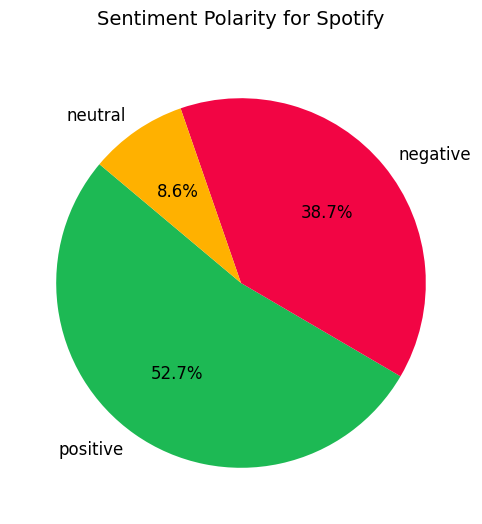

In [ ]:
##Visualisasi Polarity Sentimen
fig, ax = plt.subplots(figsize=(12, 6))
sentiment_counts = new_spotify_df['polarity'].value_counts()
sizes = sentiment_counts.values
labels = sentiment_counts.index
explode = [0.1 if i == sentiment_counts.idxmax() else 0 for i in labels]
colors = ['#1DB954','#F20544','#FFB100']
ax.pie(
    sizes, labels=labels, autopct='%1.1f%%',
    colors=colors, textprops={'fontsize': 12}, startangle=140
)
ax.set_title('Sentiment Polarity for Spotify', fontsize=14, pad=20)
plt.show()

/tmp/ipython-input-1114927012.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_spotify_df['polarity'].value_counts().index,


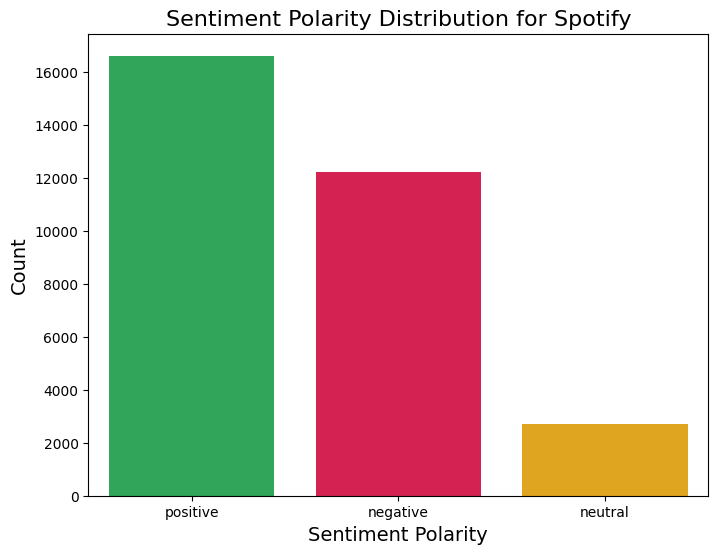

In [ ]:
# Visualisasi Data dengan Bar Chart
plt.figure(figsize=(8, 6))
colors = ['#1DB954','#F20544','#FFB100']
sns.barplot(x=new_spotify_df['polarity'].value_counts().index,
            y=new_spotify_df['polarity'].value_counts().values,
            palette=colors)
plt.xlabel("Sentiment Polarity", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Sentiment Polarity Distribution for Spotify", fontsize=16)
plt.show()

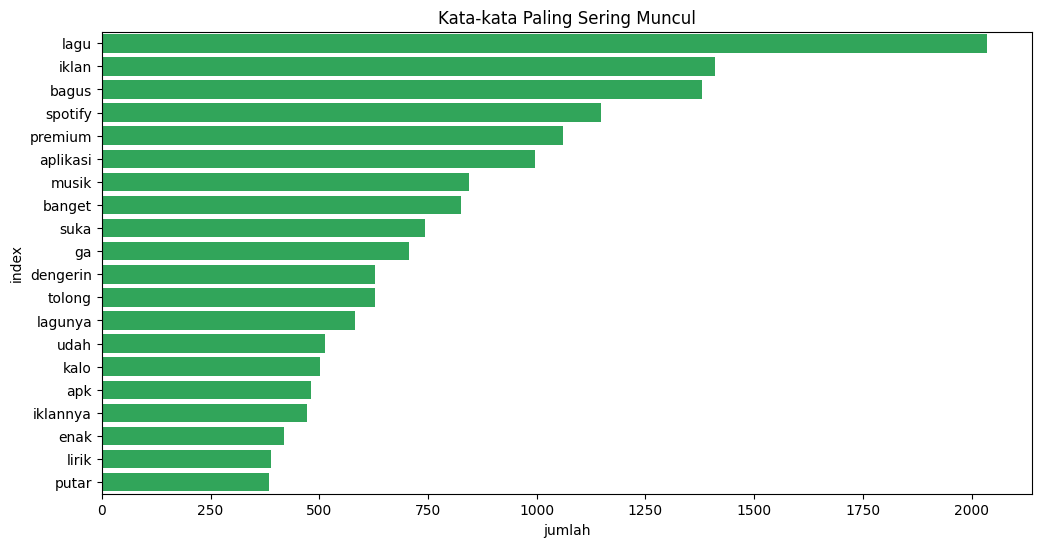

In [ ]:
# Visualisasikan kata-kata yang paling sering muncul menggunakan TF-IDF
plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()  # Membuat objek vectorizer untuk menghitung TF-IDF
X = vectorizer.fit_transform(new_spotify_df['text_final'])  # Menggunakan 'text_final'
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())  # Konversi matriks ke dalam DataFrame
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')  # Menjumlahkan nilai TF-IDF per kata
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)  # Urutkan berdasarkan frekuensi tertinggi
sns.barplot(x='jumlah', y='index', data=tfidf_df, color='#1DB954') # Plot bar chart untuk 20 kata teratas
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

## **5. Data Splitting dan ekstraksi Fitur**

Ekstraksi fitur dilakukan untuk mengubah teks menjadi bentuk numerik. Pada analisis ini digunakan dua metode, yaitu **TF-IDF dan Bag of Words (BoW)**. TF-IDF dipilih karena mampu **menurunkan bobot kata yang sering muncul namun kurang informatif**, sedangkan **BoW digunakan sebagai metode pembanding berbasis frekuensi**. Pendekatan n-gram juga digunakan untuk **menangkap konteks frasa pendek** yang tidak dapat direpresentasikan oleh unigram saja.

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = new_spotify_df['text_final']
y = new_spotify_df['polarity']

**A. Ekstraksi Fitur TF-IDF**

In [ ]:
# Ekstraksi fitur dengan TF-IDF + N-Gram (Unigram dan Bigram)
tfidf = TfidfVectorizer(max_features=20000, min_df=17, max_df=0.8,
ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(X)
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df_tfidf = pd.DataFrame(X_tfidf.toarray(),
columns=tfidf.get_feature_names_out())
# Bagi data menjadi data latih dan data uji untuk TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
X_tfidf, y, test_size=0.2, random_state=42
)
# Tampilkan dimensi fitur hasil ekstraksi
print("Dimensi fitur TF-IDF:")
print("X_train_tfidf:", X_train_tfidf.shape)
print("X_test_tfidf:", X_test_tfidf.shape)

Dimensi fitur TF-IDF:
X_train_tfidf: (25200, 4239)
X_test_tfidf: (6300, 4239)


**B. Ekstraksi Fitur BoW**

In [ ]:
# Ekstraksi fitur dengan Bag of Words (BoW) + N-Gram (Unigram dan Bigram)
bow_vectorizer = CountVectorizer(max_features=20000, stop_words='english',
ngram_range=(2, 3))

# Re-assign X to ensure it's the text data (Series of strings)
X = new_spotify_df['text_final']
y = new_spotify_df['polarity']

X_bow = bow_vectorizer.fit_transform(X)
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df_bow = pd.DataFrame(X_bow.toarray(),
columns=bow_vectorizer.get_feature_names_out())
# Bagi data menjadi data latih dan data uji untuk BoW
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
X_bow, y, test_size=0.2, random_state=42
)
# Tampilkan dimensi fitur hasil ekstraksi
print("\nDimensi fitur Bag of Words (BoW):")
print("X_train_bow:", X_train_bow.shape)
print("X_test_bow:", X_test_bow.shape)


Dimensi fitur Bag of Words (BoW):
X_train_bow: (25200, 20000)
X_test_bow: (6300, 20000)


## **Insight Digging 🦾**

## **6. MODELLING**

Analisis sentimen ini menggunakan dua algoritma, yaitu **Support Vector Machine (SVM)** dan **Logistic Regression** dan dilatih menggunakan fitur dari **TF-IDF dan BoW**. Setiap model dievaluasi berdasarkan akurasi, F1-score, dan confusion matrix.

### **MODEL SVM**

**A. SVM dengan TF-IDF, Pembagian Data 80/20 (Skema 1)**

In [ ]:
# Membuat objek model Support Vector Machine (SVM)
svm = SVC(kernel='linear', C=1)  # Kernel linear dengan C=1

# Melatih model SVM pada data pelatihan (menggunakan fitur TF-IDF)
svm.fit(X_train_tfidf, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm_tfidf = svm.predict(X_train_tfidf)   # Prediksi pada data latih
y_pred_test_svm_tfidf = svm.predict(X_test_tfidf)     # Prediksi pada data uji

# Evaluasi akurasi model SVM
accuracy_train_svm_tfidf = accuracy_score(y_train, y_pred_train_svm_tfidf)  # Akurasi pada data latih
accuracy_test_svm_tfidf = accuracy_score(y_test, y_pred_test_svm_tfidf)      # Akurasi pada data uji

# Menampilkan akurasi untuk model SVM
print('SVM - accuracy_train:', accuracy_train_svm_tfidf)
print('SVM - accuracy_test:', accuracy_test_svm_tfidf)
print("\nTF-IDF SVM - Macro F1 (test):", f1_score(y_test, y_pred_test_svm_tfidf, average="macro"))
print("\nTF-IDF SVM - Classification Report (test):")
print(classification_report(y_test, y_pred_test_svm_tfidf, digits=4))

print("TF-IDF SVM - Confusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_svm_tfidf))

SVM - accuracy_train: 0.9079761904761905
SVM - accuracy_test: 0.8614285714285714

TF-IDF SVM - Macro F1 (test): 0.6932591867848877

TF-IDF SVM - Classification Report (test):
              precision    recall  f1-score   support

    negative     0.8545    0.8958    0.8747      2400
     neutral     0.6986    0.1892    0.2978       539
    positive     0.8727    0.9447    0.9073      3361

    accuracy                         0.8614      6300
   macro avg     0.8086    0.6766    0.6933      6300
weighted avg     0.8509    0.8614    0.8427      6300

TF-IDF SVM - Confusion Matrix (test):
[[2150   14  236]
 [ 210  102  227]
 [ 156   30 3175]]


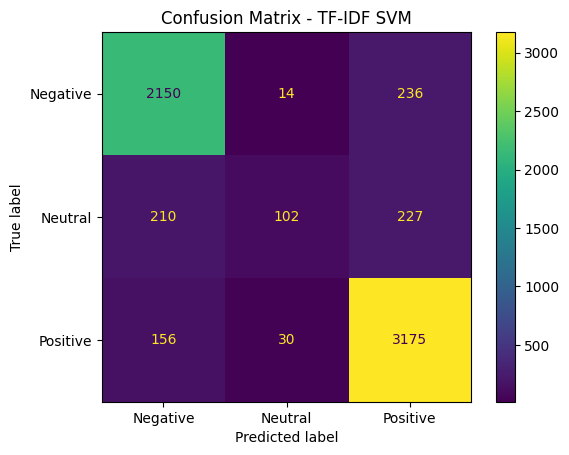

In [ ]:
##Confusion Matrix Visual for TF IDV
from sklearn.metrics import ConfusionMatrixDisplay

class_labels = ['Negative', 'Neutral', 'Positive']
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_svm_tfidf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)
disp.plot()

plt.title("Confusion Matrix - TF-IDF SVM")
plt.show()

**B. SVM dengan BoW, Pembagian Data: 80/20 (skema 2)**

In [ ]:
# Membuat objek model SVM
svm_bow = SVC(kernel='linear', C=1.0, random_state=42)
# Melatih model SVM pada data pelatihan (menggunakan fitur BoW)
svm_bow.fit(X_train_bow, y_train)
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm_bow = svm_bow.predict(X_train_bow)
y_pred_test_svm_bow = svm_bow.predict(X_test_bow)
# Evaluasi akurasi model SVM
accuracy_train_svm_bow = accuracy_score(y_train,
y_pred_train_svm_bow)
accuracy_test_svm_bow = accuracy_score(y_test, y_pred_test_svm_bow)
# Menampilkan hasil evaluasi
print('SVM (BoW) - Accuracy Train:', accuracy_train_svm_bow)
print('SVM (BoW) - Accuracy Test :', accuracy_test_svm_bow)
print("\nBoW SVM - Macro F1 (test):", f1_score(y_test, y_pred_test_svm_bow, average="macro"))
print("\nBoW SVM - Classification Report (test):")
print(classification_report(y_test, y_pred_test_svm_bow, digits=4))

print("BoW SVM - Confusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_svm_bow))

SVM (BoW) - Accuracy Train: 0.8652777777777778
SVM (BoW) - Accuracy Test : 0.6766666666666666

BoW SVM - Macro F1 (test): 0.49314201841014116

BoW SVM - Classification Report (test):
              precision    recall  f1-score   support

    negative     0.6672    0.6442    0.6555      2400
     neutral     0.1204    0.0482    0.0689       539
    positive     0.7144    0.8007    0.7551      3361

    accuracy                         0.6767      6300
   macro avg     0.5007    0.4977    0.4931      6300
weighted avg     0.6456    0.6767    0.6584      6300

BoW SVM - Confusion Matrix (test):
[[1546   98  756]
 [ 193   26  320]
 [ 578   92 2691]]


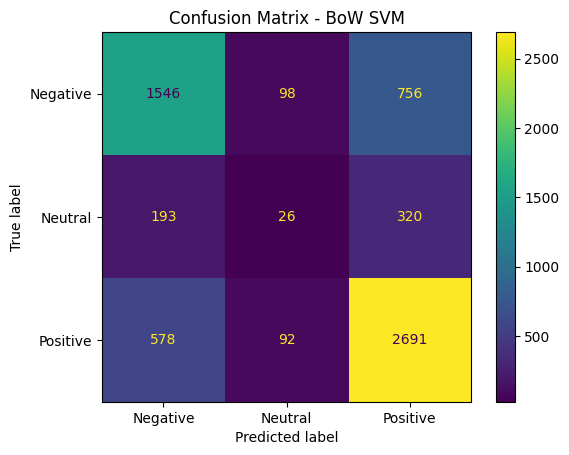

In [ ]:
##Confusion Matrix Visual for SVM BoW
class_labels = ['Negative', 'Neutral', 'Positive']
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_svm_bow)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)
disp.plot()

plt.title("Confusion Matrix - BoW SVM")
plt.show()

### **MODEL LOGISTIC REGRESSION**

**A. LG dengan TF-IDF, Pembagian Data 80/20 (Skema 3)**

In [ ]:
# Logistic Regression dengan TF-IDF
lr_tfidf = LogisticRegression(
    max_iter=1000,
    random_state=42
)

# Training
lr_tfidf.fit(X_train_tfidf, y_train)

# Prediksi
y_pred_train_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_pred_test_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

# Evaluasi
accuracy_train_lr_tfidf = accuracy_score(y_train, y_pred_train_lr_tfidf)
accuracy_test_lr_tfidf = accuracy_score(y_test, y_pred_test_lr_tfidf)
f1_lr_tfidf = f1_score(y_test, y_pred_test_lr_tfidf, average='macro')

print("Logistic Regression TF-IDF - Accuracy Train:", accuracy_train_lr_tfidf)
print("Logistic Regression TF-IDF - Accuracy Test :", accuracy_test_lr_tfidf)
print("\nTF-IDF LR - Macro F1 (test):", f1_lr_tfidf)
print("\nTF-IDF LR - Classification Report (test):")
print(classification_report(y_test, y_pred_test_lr_tfidf, digits=4))

print("TF-IDF LR - Confusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_lr_tfidf))

Logistic Regression TF-IDF - Accuracy Train: 0.8976587301587302
Logistic Regression TF-IDF - Accuracy Test : 0.8612698412698413

TF-IDF LR - Macro F1 (test): 0.6798718504664718

TF-IDF LR - Classification Report (test):
              precision    recall  f1-score   support

    negative     0.8517    0.8971    0.8738      2400
     neutral     0.7981    0.1540    0.2582       539
    positive     0.8697    0.9491    0.9077      3361

    accuracy                         0.8613      6300
   macro avg     0.8398    0.6667    0.6799      6300
weighted avg     0.8567    0.8613    0.8392      6300

TF-IDF LR - Confusion Matrix (test):
[[2153    5  242]
 [ 220   83  236]
 [ 155   16 3190]]


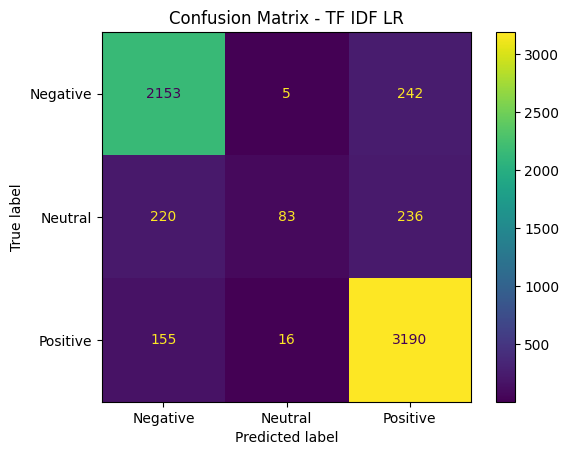

In [ ]:
##Confusion Matrix Visual for LR BoW
class_labels = ['Negative', 'Neutral', 'Positive']
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_lr_tfidf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)
disp.plot()

plt.title("Confusion Matrix - TF IDF LR")
plt.show()

**B. LG dengan BoW, Pembagian Data 80/20 (Skema 4)**

In [ ]:
# Logistic Regression dengan BoW
lr_bow = LogisticRegression(
    max_iter=1000,
    random_state=42)

# Training
lr_bow.fit(X_train_bow, y_train)

# Prediksi
y_pred_train_lr_bow = lr_bow.predict(X_train_bow)
y_pred_test_lr_bow = lr_bow.predict(X_test_bow)

# Evaluasi
accuracy_train_lr_bow = accuracy_score(y_train, y_pred_train_lr_bow)
accuracy_test_lr_bow = accuracy_score(y_test, y_pred_test_lr_bow)

print('BoW LR - Accuracy Train :', accuracy_train_lr_bow)
print('BoW LR - Accuracy Test  :', accuracy_test_lr_bow)
print("\nBoW LR - Macro F1 (test):", f1_score(y_test, y_pred_test_lr_bow, average='macro'))
print("\nBoW LR - Classification Report (test):")
print(classification_report(y_test, y_pred_test_lr_bow, digits=4))
print("BoW LR - Confusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_lr_bow))

BoW LR - Accuracy Train : 0.854484126984127
BoW LR - Accuracy Test  : 0.7014285714285714

BoW LR - Macro F1 (test): 0.5032440002121267

BoW LR - Classification Report (test):
              precision    recall  f1-score   support

    negative     0.6891    0.6742    0.6816      2400
     neutral     0.1651    0.0334    0.0556       539
    positive     0.7242    0.8280    0.7726      3361

    accuracy                         0.7014      6300
   macro avg     0.5261    0.5119    0.5032      6300
weighted avg     0.6630    0.7014    0.6766      6300

BoW LR - Confusion Matrix (test):
[[1618   42  740]
 [ 201   18  320]
 [ 529   49 2783]]


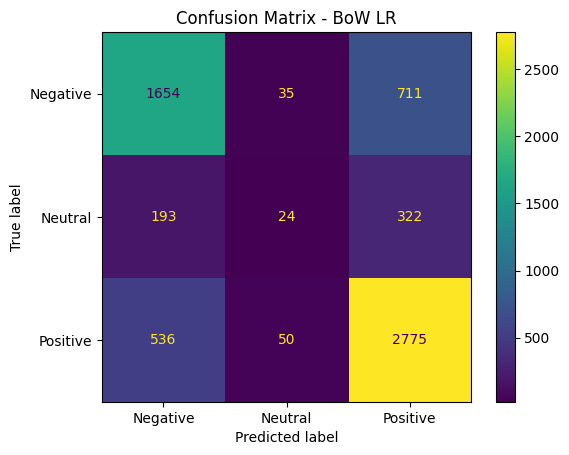

In [ ]:
##Confusion Matrix Visual for LR BoW
class_labels = ['Negative', 'Neutral', 'Positive']
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_lr_bow)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)
disp.plot()

plt.title("Confusion Matrix - BoW LR")
plt.show()

# **Inference Using SVM TF IDF**

Model terbaik (SVM dengan TF-IDF) diimplementasikan dalam sistem prediksi real-time yang dapat mengklasifikasikan sentimen dari input teks baru. Input pengguna diproses melalui pipeline preprocessing yang sama, diubah menjadi vektor TF-IDF, dan diprediksi oleh model sentimennya.

In [ ]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing sesuai pipeline
kalimat_baru_cleaned = cleaning_text(kalimat_baru)
kalimat_baru_casefolded = casefolding_text(kalimat_baru_cleaned)
kalimat_baru_tokenized = tokenizing_text(kalimat_baru_casefolded)
kalimat_baru_filtered = filtering_text(kalimat_baru_tokenized)
kalimat_baru_final = to_sentence(kalimat_baru_filtered)
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_tfidf, y_train)

# Menggunakan objek tfidf yang sudah di-fit sebelumnya
X_kalimat_baru_tfidf = tfidf.transform([kalimat_baru_final])

# Melakukan prediksi
prediksi_sentimen = svm.predict(X_kalimat_baru_tfidf)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'negative':
    print("Sentimen kalimat baru adalah NEGATIF 😟")
elif prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF 😄")
else:
    print("Sentimen kalimat baru adalah NETRAL 🙂")

Masukkan kalimat baru: ada liriknya
Sentimen kalimat baru adalah POSITIF 😄


# **Summary**

Berdasarkan hasil pengujian dengan **pembagian data 80 persen data latih dan 20 persen data uji**, empat skema pemodelan analisis sentimen diuji, yaitu **SVM dan Logistic Regression** dengan representasi **fitur TF-IDF dan Bag of Words**. Hasil evaluasi menunjukkan bahwa **model berbasis TF-IDF secara konsisten memberikan performa lebih baik** dibandingkan Bag of Words pada kedua algoritma.  

Urutan Skema terbaik sampai terendah
1.  **SVM dengan TF-IDF** menghasilkan performa terbaik dengan nilai **accuracy test 86,83% dan macro F1-score 0,69**
2.   **Logistic Regression dengan TF-IDF** memperoleh **accuracy test 86,13% dan macro F1-score 0,68**
3. **Logistic Regression dengan BoW** menghasilkan **accuracy 70,14% persen dan macro F1-score 0,51**
4. **SVM dengan BoW** (overfitting) yang ditandai oleh accuracy train yang sangat tinggi yaitu 86% namun accuracy test hanya **67,66%** dengan **macro F1-score 0,49**



---


# **Insight**


1.   Mayoritas ulasan pengguna Spotify **bersentimen positif (52,7%)**. Hal ini mengindikasikan secara umum pengguna merasa puas terhadap layanan yang diberikan. Namun, proporsi sentimen negatif yang cukup besar **(38,7%)** menunjukkan masih adanya aspek layanan yang perlu diperbaiki.
2.   Kata-kata yang sering muncul dalam **ulasan positif** berkaitan dengan **pengalaman mendengarkan** musik dan **kemudahan penggunaan** aplikasi. Sebaliknya, pada **ulasan **negatif**, banyak ditemukan keluhan terkait **frekuensi iklan** dan **gangguan saat memutar musik**, khususnya pada pengguna **versi gratis**.
3. **Rendahnya performa model pada kelas netral** menunjukkan bahwa ulasan netral cenderung memiliki kata-kata ambigu dan tidak mengandung ekspresi emosi yang kuat, sehingga sulit dibedakan dari sentimen positif maupun negatif.

